# GCN - LSTM on 29 companies from DJIA Index - 200 Epochs
Student Name: Girija Madireddy                  
Student id: x21235929                       
Master of Science in Data Analytics

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.optim as optim
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import warnings
warnings.simplefilter("ignore")

In [2]:
# Downloading stock data
tickers = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']
data = {ticker: yf.download(ticker, start="2012-01-01", end="2014-07-01") for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
for ticker, df in data.items():
    print(f"First 5 records for {ticker}:")
    print(df.head(), "\n")  # Prints the first 5 rows of the DataFrame


First 5 records for CSCO:
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  18.549999  18.860001  18.480000  18.629999  13.024627  41236600
2012-01-04  18.440001  19.000000  18.350000  18.990000  13.276310  52927700
2012-01-05  18.930000  19.000000  18.670000  18.920000  13.227374  37865300
2012-01-06  18.950001  19.000000  18.830000  18.850000  13.178436  27796900
2012-01-09  18.870001  19.100000  18.790001  18.969999  13.262328  37811500 

First 5 records for TRV:
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-01-03  60.110001  60.320000  58.980000  58.990002  44.468449  3522500
2012-01-04  58.840000  59.070000  58.139999  58.750000  44.287544  3934500
2012-01-05  58.360001  59.360001  58.080002  59.330002  44.724747  4748600
2012-01-06  59.570000  59.730000  59.110

In [4]:
for ticker, df in data.items():
    num_records = df.shape[0]  # Number of rows in the DataFrame
    print(f"{ticker} has {num_records} records")


CSCO has 626 records
TRV has 626 records
IBM has 626 records
PFE has 626 records
JNJ has 626 records
AXP has 626 records
GS has 626 records
GOOGL has 626 records
GE has 626 records
KO has 626 records
VZ has 626 records
BA has 626 records
NKE has 626 records
CVX has 626 records
AMZN has 626 records
UNH has 626 records
WMT has 626 records
MMM has 626 records
JPM has 626 records
DIS has 626 records
MCD has 626 records
CAT has 626 records
MRK has 626 records
XOM has 626 records
MSFT has 626 records
HD has 626 records
INTC has 626 records
PG has 626 records
AAPL has 626 records


In [5]:
# Preprocessing
features = []
labels = []
for ticker, df in data.items():
    normalized = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
    features.append(normalized.values)
    labels.append(df['Close'].diff().apply(lambda x: 1 if x > 0 else 0).values)
features = np.array(features)
labels = np.array(labels)
# Print the first 5 records of the first 5 stocks
num_columns = features.shape[0]
print("Number of columns in 'features':", num_columns)

print(features.shape[1])
print(features.shape[0])



Number of columns in 'features': 29
626
29


In [6]:
# list of tickers corresponding to the rows in 'features'
tickers = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']

# Print the feature values for the first few records of each stock
for ticker, feature_values in zip(tickers, features):
    print(f"{ticker}: {feature_values[:5]}")  


CSCO: [0.31172287 0.34369451 0.33747784 0.33126117 0.34191827]
TRV: [0.054738   0.04854121 0.06351673 0.06403304 0.07281177]
IBM: [0.31395347 0.29627904 0.2758141  0.22651152 0.20441859]
PFE: [0.08644077 0.06949168 0.05508483 0.05254242 0.07372891]
JNJ: [0.09322415 0.08412925 0.0823102  0.06934977 0.07162349]
AXP: [0.00316919 0.         0.01183177 0.00063382 0.00316919]
GS: [0.04933802 0.04232203 0.04051151 0.02738484 0.04175628]
GOOGL: [0.16087848 0.16521968 0.15119794 0.13759989 0.095913  ]
GE: [0.02125503 0.04149801 0.04048583 0.05060732 0.07186235]
KO: [0.16414805 0.14121932 0.12402317 0.10109443 0.10109443]
VZ: [0.1712449  0.14085329 0.12507302 0.08942154 0.09175918]
BA: [0.09049661 0.09192278 0.08155064 0.08738501 0.09451577]
NKE: [0.12552125 0.14512096 0.14428697 0.14192381 0.14692799]
CVX: [0.38173372 0.37653814 0.34700568 0.32540324 0.35767014]
AMZN: [0.01341292 0.00683623 0.00726892 0.0289027  0.01137939]
UNH: [0.03563624 0.05908107 0.07002194 0.07596125 0.07408574]
WMT: [0.1

In [7]:
# Correlation matrix and edge creation
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in data.items()})
correlation_matrix = close_prices.corr()
print(correlation_matrix)
correlation_threshold = 0.5
edges = []
num_nodes = len(tickers)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            edges.append((i, j))
            edges.append((j, i))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


           CSCO       TRV       IBM       PFE       JNJ       AXP        GS  \
CSCO   1.000000  0.753532 -0.214252  0.698086  0.801310  0.725163  0.854623   
TRV    0.753532  1.000000 -0.326865  0.939359  0.937928  0.872568  0.910345   
IBM   -0.214252 -0.326865  1.000000 -0.365430 -0.461445 -0.492341 -0.313952   
PFE    0.698086  0.939359 -0.365430  1.000000  0.920057  0.890285  0.913680   
JNJ    0.801310  0.937928 -0.461445  0.920057  1.000000  0.956993  0.900277   
AXP    0.725163  0.872568 -0.492341  0.890285  0.956993  1.000000  0.872512   
GS     0.854623  0.910345 -0.313952  0.913680  0.900277  0.872512  1.000000   
GOOGL  0.699497  0.870016 -0.491904  0.917046  0.933904  0.969856  0.887439   
GE     0.704631  0.926598 -0.418711  0.927279  0.941692  0.931726  0.899683   
KO     0.472152  0.743079  0.014186  0.677999  0.678136  0.620087  0.559432   
VZ     0.608277  0.864950 -0.170356  0.842579  0.794673  0.706920  0.733235   
BA     0.706860  0.833707 -0.607703  0.854680  0.934

In [8]:
torch.tensor(edges, dtype=torch.long)

tensor([[ 0,  1],
        [ 1,  0],
        [ 0,  3],
        ...,
        [27, 24],
        [25, 27],
        [27, 25]])

In [9]:
torch.tensor(edges, dtype=torch.long).t()

tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]])

In [10]:
torch.tensor(edges, dtype=torch.long).t().contiguous()

tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]])

In [11]:
num_edges = edge_index.shape[1]
print("Number of edges:", num_edges)

Number of edges: 572


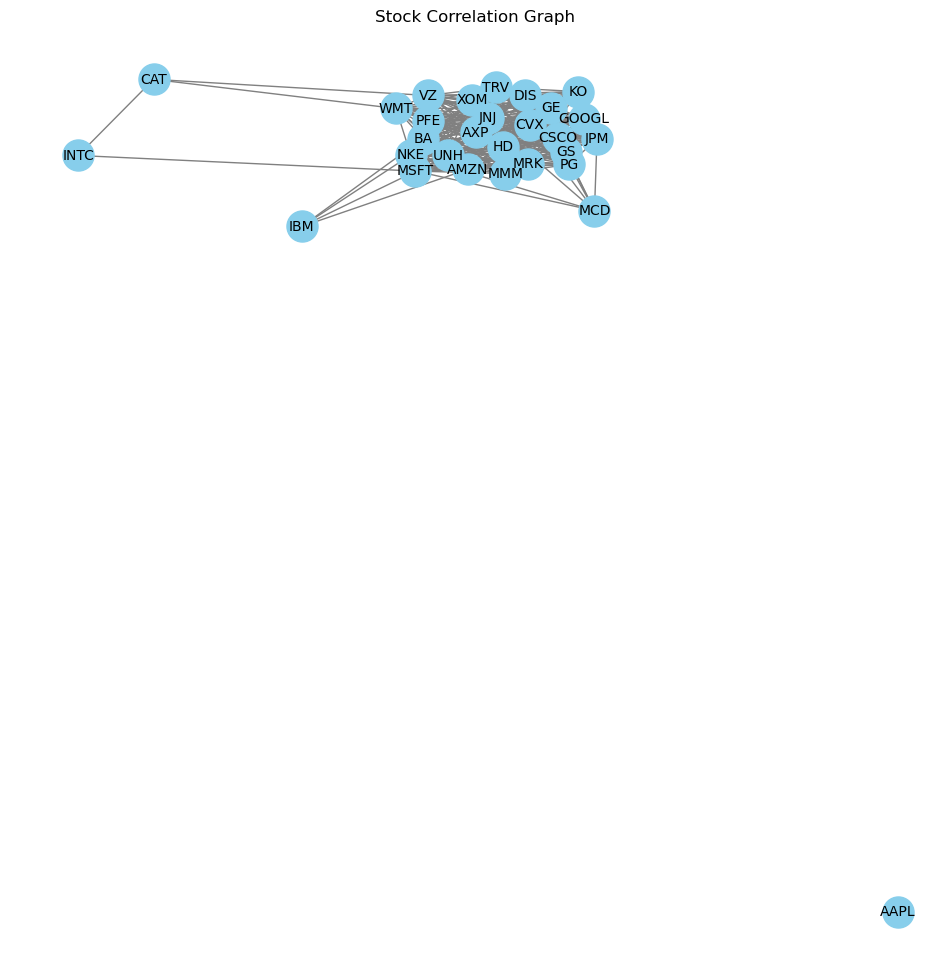

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
for ticker in tickers:
    G.add_node(ticker)

# Add edges based on the correlation matrix
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            G.add_edge(tickers[i], tickers[j])

# Draw the graph
plt.figure(figsize=(12, 12))  # Set the figure size
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Stock Correlation Graph")
plt.axis('off')  # Turn off the axis
plt.show()


In [13]:
import torch
from torch_geometric.data import Data


# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the features NumPy array to a PyTorch tensor
x = torch.tensor(features, dtype=torch.float).to(device)

# Convert the NumPy array of labels to a PyTorch tensor
y = torch.tensor(labels, dtype=torch.long).to(device) 

# edge_index tensor
edge_index = edge_index.to(device)

# Create the Data object with features, edge index, and labels
graph_data = Data(x=x, edge_index=edge_index, y=y)

print(x,y,edge_index)
print(graph_data)


tensor([[0.3117, 0.3437, 0.3375,  ..., 0.8464, 0.8508, 0.8641],
        [0.0547, 0.0485, 0.0635,  ..., 0.9693, 0.9566, 0.9605],
        [0.3140, 0.2963, 0.2758,  ..., 0.1760, 0.2072, 0.1970],
        ...,
        [0.4477, 0.4970, 0.5220,  ..., 0.9870, 1.0000, 0.9974],
        [0.2892, 0.2881, 0.2774,  ..., 0.7402, 0.7555, 0.7391],
        [0.0664, 0.0735, 0.0883,  ..., 0.7888, 0.8131, 0.8344]],
       device='cuda:0') tensor([[0, 1, 0,  ..., 0, 1, 1],
        [0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 1, 1, 1]], device='cuda:0') tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]], device='cuda:0')
Data(x=[29, 626], edge_index=[2, 572], y=[29, 626])


In [14]:
# Verifying if GPU is available
print(torch.cuda.is_available())

True


In [15]:
# number of GPU available
print(torch.cuda.device_count())


1


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNLSTM(nn.Module):
    def __init__(self, num_features, gcn_hidden, lstm_hidden, num_classes, num_nodes):
        super(GCNLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.lstm_hidden = lstm_hidden  # Ensure this attribute is correctly set
        self.gcn = GCNConv(num_features, gcn_hidden)
        self.lstm = nn.LSTM(gcn_hidden, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x, edge_index):
        # Reshape x for GCN: Flatten node and day dimensions
        x = x.view(-1, num_features)

        # Apply GCN
        x = F.relu(self.gcn(x, edge_index))

        # Reshape for LSTM: [num_days, num_nodes, gcn_hidden]
        x = x.view(-1, self.num_nodes, x.size(-1))

        # Apply LSTM
        lstm_out, _ = self.lstm(x)

        # Classifier
        lstm_out = lstm_out.reshape(-1, lstm_out.size(-1))
        out = self.fc(lstm_out)

        return out

In [17]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with updated number of features
num_features = 1  # Only one feature per stock per day
gcn_hidden = 64
lstm_hidden = 32
num_classes = 2
num_nodes = 29
num_days = 626

model = GCNLSTM(num_features, gcn_hidden, lstm_hidden, num_classes, num_nodes).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    
    # x is already on the correct device and has shape [num_nodes, num_days]
    # Forward pass for the entire graph
    out = model(x, edge_index)

    # Reshape output and labels to be compatible with CrossEntropyLoss
    out = out.view(num_nodes * num_days, num_classes)
    y = y.view(-1)

    # Compute loss on the entire graph
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.6981698870658875
Epoch 1, Loss: 0.6969365477561951
Epoch 2, Loss: 0.6958561539649963
Epoch 3, Loss: 0.694926381111145
Epoch 4, Loss: 0.6941462755203247
Epoch 5, Loss: 0.6935173869132996
Epoch 6, Loss: 0.6930398941040039
Epoch 7, Loss: 0.6927139163017273
Epoch 8, Loss: 0.6925332546234131
Epoch 9, Loss: 0.6924838423728943
Epoch 10, Loss: 0.6925368905067444
Epoch 11, Loss: 0.6926486492156982
Epoch 12, Loss: 0.6927682161331177
Epoch 13, Loss: 0.6928558945655823
Epoch 14, Loss: 0.6928911209106445
Epoch 15, Loss: 0.6928732395172119
Epoch 16, Loss: 0.6928134560585022
Epoch 17, Loss: 0.6927267909049988
Epoch 18, Loss: 0.6926295161247253
Epoch 19, Loss: 0.6925340294837952
Epoch 20, Loss: 0.6924496293067932
Epoch 21, Loss: 0.6923810839653015
Epoch 22, Loss: 0.6923301219940186
Epoch 23, Loss: 0.692296028137207
Epoch 24, Loss: 0.6922760605812073
Epoch 25, Loss: 0.6922668814659119
Epoch 26, Loss: 0.692264974117279
Epoch 27, Loss: 0.6922665238380432
Epoch 28, Loss: 0.692268729209899

In [18]:
# Downloading stock data
tickers_val = ['CSCO', 'TRV', 'IBM', 'PFE', 'JNJ', 'AXP', 'GS', 'GOOGL', 'GE', 'KO', 'VZ', 'BA', 'NKE', 'CVX', 'AMZN', 'UNH', 'WMT', 'MMM', 'JPM', 'DIS', 'MCD', 'CAT', 'MRK', 'XOM', 'MSFT', 'HD', 'INTC', 'PG', 'AAPL']
data_val = {ticker_val: yf.download(ticker_val, start="2014-07-01", end="2016-07-01") for ticker_val in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [19]:
# Preprocessing
features_val = []
labels_val = []
for ticker_val, df_val in data_val.items():
    normalized = (df_val['Close'] - df_val['Close'].min()) / (df_val['Close'].max() - df_val['Close'].min())
    features_val.append(normalized.values)
    labels_val.append(df_val['Close'].diff().apply(lambda x: 1 if x > 0 else 0).values)
features_val = np.array(features_val)
labels_val = np.array(labels_val)
# Print the first 5 records of the first 5 stocks
num_columns = features_val.shape[0]
print("Number of columns in 'features':", num_columns)

print(features_val.shape[1])
print(features_val.shape[0])

Number of columns in 'features': 29
505
29


In [20]:
# Correlation matrix and edge creation
close_prices = pd.DataFrame({ticker: df['Close'] for ticker, df in data.items()})
correlation_matrix = close_prices.corr()
print(correlation_matrix)
correlation_threshold = 0.5
edges = []
num_nodes = len(tickers)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            edges.append((i, j))
            edges.append((j, i))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

           CSCO       TRV       IBM       PFE       JNJ       AXP        GS  \
CSCO   1.000000  0.753532 -0.214252  0.698086  0.801310  0.725163  0.854623   
TRV    0.753532  1.000000 -0.326865  0.939359  0.937928  0.872568  0.910345   
IBM   -0.214252 -0.326865  1.000000 -0.365430 -0.461445 -0.492341 -0.313952   
PFE    0.698086  0.939359 -0.365430  1.000000  0.920057  0.890285  0.913680   
JNJ    0.801310  0.937928 -0.461445  0.920057  1.000000  0.956993  0.900277   
AXP    0.725163  0.872568 -0.492341  0.890285  0.956993  1.000000  0.872512   
GS     0.854623  0.910345 -0.313952  0.913680  0.900277  0.872512  1.000000   
GOOGL  0.699497  0.870016 -0.491904  0.917046  0.933904  0.969856  0.887439   
GE     0.704631  0.926598 -0.418711  0.927279  0.941692  0.931726  0.899683   
KO     0.472152  0.743079  0.014186  0.677999  0.678136  0.620087  0.559432   
VZ     0.608277  0.864950 -0.170356  0.842579  0.794673  0.706920  0.733235   
BA     0.706860  0.833707 -0.607703  0.854680  0.934

In [21]:
import torch
from torch_geometric.data import Data

# Convert the features NumPy array to a PyTorch tensor
x_val = torch.tensor(features, dtype=torch.float).to(device)

# Convert the NumPy array of labels to a PyTorch tensor
y_val = torch.tensor(labels, dtype=torch.long).to(device)  

# The edge_index tensor
edge_index = edge_index.to(device)

# Create the Data object with features, edge index, and labels
graph_data = Data(x_val=x_val, edge_index=edge_index, y_val=y_val)

print(x_val,y_val,edge_index)



tensor([[0.3117, 0.3437, 0.3375,  ..., 0.8464, 0.8508, 0.8641],
        [0.0547, 0.0485, 0.0635,  ..., 0.9693, 0.9566, 0.9605],
        [0.3140, 0.2963, 0.2758,  ..., 0.1760, 0.2072, 0.1970],
        ...,
        [0.4477, 0.4970, 0.5220,  ..., 0.9870, 1.0000, 0.9974],
        [0.2892, 0.2881, 0.2774,  ..., 0.7402, 0.7555, 0.7391],
        [0.0664, 0.0735, 0.0883,  ..., 0.7888, 0.8131, 0.8344]],
       device='cuda:0') tensor([[0, 1, 0,  ..., 0, 1, 1],
        [0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 1, 1, 1]], device='cuda:0') tensor([[ 0,  1,  0,  ..., 27, 25, 27],
        [ 1,  0,  3,  ..., 24, 27, 25]], device='cuda:0')


In [22]:
# Validation Phase
model.eval()
with torch.no_grad():
    # `x_val`, `edge_index_val`, and `y_val` for validation are defined
    
    x_val = x_val.to(device)
    edge_index_val = edge_index.to(device)
    y_val = y_val.to(device)

    # Forward pass for the entire graph
    val_out = model(x_val, edge_index_val)

    # Reshape output and labels to be compatible with CrossEntropyLoss
    val_out = val_out.view(num_nodes * num_days, num_classes)  
    y_val_flat = y_val.view(-1)

    # Compute validation loss
    val_loss = criterion(val_out, y_val_flat)

    # Get predictions and compare with actual labels
    _, val_pred = val_out.max(dim=1)
    val_correct = int(val_pred.eq(y_val_flat).sum().item())
    val_accuracy = val_correct / y_val_flat.size(0)  # Total number of label elements

print(f'Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}')


Validation Loss: 0.5567276477813721, Validation Accuracy: 0.8646028423487937


In [23]:
# out is the output of  model for multiple days for all stocks

daily_aggregated_predictions = []
num_days=505

for day in range(num_days):
    # Get predictions for all stocks for this day
    daily_predictions = val_out[day * num_nodes: (day + 1) * num_nodes]

    # Convert these predictions to labels (0 or 1)
    daily_labels = torch.argmax(daily_predictions, dim=1)

    # Aggregate these labels using a majority vote
    # If the sum of daily labels is greater than half of num_nodes, the aggregated label is 1, else 0
    aggregated_label = 1 if torch.sum(daily_labels).item() > num_nodes / 2 else 0

    daily_aggregated_predictions.append(aggregated_label)



In [24]:
# Download DJIA data
djia = yf.download('^DJI', start="2014-07-01", end="2016-07-01")  # Replace dates as needed

# Create daily labels
# Label is 1 if the closing price is higher than the previous day, 0 otherwise
djia['Label'] = (djia['Close'] > djia['Close'].shift(1)).astype(int)

# Drop the first row as it won't have a label
djia = djia.dropna()

# Now djia['Label'] contains your daily labels
print(djia[['Close', 'Label']])


[*********************100%%**********************]  1 of 1 completed
                   Close  Label
Date                           
2014-07-01  16956.070312      0
2014-07-02  16976.240234      1
2014-07-03  17068.259766      1
2014-07-07  17024.210938      0
2014-07-08  16906.619141      0
...                  ...    ...
2016-06-24  17400.750000      0
2016-06-27  17140.240234      0
2016-06-28  17409.720703      1
2016-06-29  17694.679688      1
2016-06-30  17929.990234      1

[505 rows x 2 columns]


In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# daily_aggregated_predictions` is a list of model's daily aggregated predictions
daily_predictions = daily_aggregated_predictions  


# Extract actual labels into a list
actual_djia_labels = djia['Label'].tolist()

# Calculate metrics for each day
daily_accuracy = accuracy_score(actual_djia_labels, daily_predictions)
daily_precision = precision_score(actual_djia_labels, daily_predictions)
daily_recall = recall_score(actual_djia_labels, daily_predictions)
daily_f1 = f1_score(actual_djia_labels, daily_predictions)
daily_conf_matrix = confusion_matrix(actual_djia_labels, daily_predictions)

print("Daily Accuracy:", daily_accuracy)
print("Daily Precision:", daily_precision)
print("Daily Recall:", daily_recall)
print("Daily F1 Score:", daily_f1)
print("Daily Confusion Matrix:\n", daily_conf_matrix)


Daily Accuracy: 0.5326732673267327
Daily Precision: 0.5360230547550432
Daily Recall: 0.7126436781609196
Daily F1 Score: 0.611842105263158
Daily Confusion Matrix:
 [[ 83 161]
 [ 75 186]]
